In [1]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [2]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [3]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [4]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [5]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [6]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'       ])

y_test = nba_test.away_cover

In [7]:

X_test.shape

(150, 148)

In [8]:
X_train.shape

(711, 148)

### Interaction Terms

At one point in the modeling process I hoped to get better results by including some interactions in the model.  They did not appear significant and added noise so they were removed, but I left the code in case I wanted to reinsert them later. 

In [9]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


### Scale and Transform the data

I use standard scaler scale the data and then do a principal components analysis to transform the data.  I do not care about inference in this case only prediction and there is a good deal of correlation between variables. So I decided to transform the data to reduce the number and get orthoginal features without losing much information.  I retain 99% of the variance.

In [10]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [11]:
from sklearn.decomposition import PCA

In [12]:
pc = PCA(n_components=75)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [13]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.11694139 0.10466322 0.06263363 0.04348807 0.04020162 0.03739641
 0.03465436 0.03171007 0.03088486 0.02746436 0.0268335  0.02449559
 0.02349233 0.01981358 0.0187899  0.01781639 0.01615334 0.01557077
 0.01526551 0.01447885 0.01406536 0.01263087 0.01230269 0.01185432
 0.01148084 0.01019796 0.01010359 0.00978173 0.00931831 0.00867519
 0.00824706 0.00784966 0.00771266 0.00722275 0.00688001 0.00657454
 0.00636737 0.00601614 0.00578821 0.00543573 0.00496192 0.00474887
 0.00467484 0.0045144  0.00415594 0.00392611 0.00377081 0.0036287
 0.00338606 0.00335798 0.00319686 0.00307144 0.00295852 0.00272001
 0.00264951 0.00254457 0.00240447 0.0023217  0.00207763 0.00197976
 0.0019091  0.00185137 0.0018229  0.00167727 0.00158738 0.00148908
 0.00139441 0.00136833 0.00132081 0.00125975 0.00115425 0.00110094
 0.00104171 0.00099819 0.00097247]
Cumulative explained variance:  [0.11694139 0.22160461 0.28423824 0.32772631 0.36792792 0.40532433
 0.43997869 0.47168876 0.502573

### Logistic Regression

The first model I tested out was the logistic regression on good thing about the NBA data is that much of the data seemed to be normally distributed and my transformed features are uncorrelated so I thought

In [14]:
lr = LogisticRegressionCV(Cs = [1000],
                         max_iter=1000,
                         penalty = 'l1',
                         tol = .00001,
                         solver ='saga' )


lr.fit(X_train_pc, y_train)
print(lr.score(X_train_pc, y_train))


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6427566807313643


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [15]:
lr.score(X_test_pc, y_test)

0.5533333333333333

In [16]:
y_hat_lr   = lr.predict(X_train_pc)
y_hat_lrp  = lr.predict_proba(X_train_pc)
y_hat_lrt  = lr.predict(X_test_pc)
y_hat_lrtp = lr.predict_proba(X_test_pc)

In [17]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61       333
           1       0.66      0.69      0.67       378

   micro avg       0.64      0.64      0.64       711
   macro avg       0.64      0.64      0.64       711
weighted avg       0.64      0.64      0.64       711



In [18]:
print(classification_report(y_test, y_hat_lrt))

              precision    recall  f1-score   support

           0       0.53      0.64      0.58        73
           1       0.58      0.47      0.52        77

   micro avg       0.55      0.55      0.55       150
   macro avg       0.56      0.56      0.55       150
weighted avg       0.56      0.55      0.55       150



In [19]:
confusion_matrix( y_train, y_hat_lr)

array([[198, 135],
       [119, 259]])

In [20]:
confusion_matrix( y_test, y_hat_lrt)

array([[47, 26],
       [41, 36]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [21]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.05, .15, .1]
    }

In [22]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5672842759646295
{'C': 0.1, 'kernel': 'linear'}


In [23]:
gs.score(X_test_pc, y_test)

0.5901639344262295

In [24]:
#predict categories and  probabilities for svc model

y_hat_svc   = gs.predict(X_train_pc)
y_hat_svcp  = gs.predict_proba(X_train_pc)
y_hat_svct  = gs.predict(X_test_pc)
y_hat_svctp = gs.predict_proba(X_test_pc)

In [25]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       333
           1       0.67      0.72      0.69       378

   micro avg       0.66      0.66      0.66       711
   macro avg       0.66      0.65      0.65       711
weighted avg       0.66      0.66      0.66       711



In [26]:
print(classification_report(y_test, y_hat_svct))

              precision    recall  f1-score   support

           0       0.54      0.66      0.59        73
           1       0.59      0.47      0.52        77

   micro avg       0.56      0.56      0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.57      0.56      0.56       150



In [27]:
confusion_matrix( y_train, y_hat_svc)

array([[196, 137],
       [106, 272]])

In [28]:
confusion_matrix( y_test, y_hat_svct)

array([[48, 25],
       [41, 36]])

### Neural Network

I also wanted to try fitting a neural network.  I do not care about the inference implications, but I found that the neural network had to much variance depending on starting weights so I decided not to use it in predictions.

I need to do more research and practice with setting up Neural Networks before incorporating its predictions

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [96]:
model = Sequential()
model.add(Dense(75, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.85))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [97]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =10, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/10
711/711 [==============================] - 0s 497us/step - loss: 2.2097 - acc: 0.4796 - val_loss: 1.7867 - val_acc: 0.5133
Epoch 2/10
711/711 [==============================] - 0s 23us/step - loss: 2.1588 - acc: 0.4965 - val_loss: 1.6991 - val_acc: 0.5133
Epoch 3/10
711/711 [==============================] - 0s 19us/step - loss: 1.9733 - acc: 0.5077 - val_loss: 1.6215 - val_acc: 0.5200
Epoch 4/10
711/711 [==============================] - 0s 17us/step - loss: 2.1164 - acc: 0.4529 - val_loss: 1.5539 - val_acc: 0.5200
Epoch 5/10
711/711 [==============================] - 0s 17us/step - loss: 1.9657 - acc: 0.4979 - val_loss: 1.4970 - val_acc: 0.5133
Epoch 6/10
711/711 [==============================] - 0s 18us/step - loss: 1.8601 - acc: 0.5091 - val_loss: 1.4502 - val_acc: 0.5133
Epoch 7/10
711/711 [==============================] - 0s 23us/step - loss: 1.7867 - acc: 0.5035 - val_loss: 1.4087 - val_acc: 0.5200
Epoch 8/10
711/711 [==

In [98]:
#returns a probability

y_hat_nnp = model.predict(X_train_pc)
y_hat_nntp = model.predict(X_test_pc)


In [99]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [200],
             'max_depth'         : [3],
             'min_samples_split' : [120],
             'min_samples_leaf'  : [10] }

gs1 = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv =5)
gs1.fit(X_train_pc, y_train)
print(gs1.best_score_)
print(gs1.best_params_)



0.531133631413552
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 120, 'n_estimators': 200}


In [100]:
gs1.score(X_test_pc, y_test)

0.5396825396825397

In [101]:
y_hat_rf   = gs1.predict(X_train_pc)
y_hat_rfp  = gs1.predict_proba(X_train_pc)
y_hat_rft  = gs1.predict(X_test_pc)
y_hat_rftp = gs1.predict_proba(X_test_pc)

In [102]:
print(classification_report(y_train, y_hat_rf))

              precision    recall  f1-score   support

           0       0.91      0.34      0.50       333
           1       0.63      0.97      0.76       378

   micro avg       0.68      0.68      0.68       711
   macro avg       0.77      0.66      0.63       711
weighted avg       0.76      0.68      0.64       711



In [103]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.62      0.21      0.31        73
           1       0.54      0.88      0.67        77

   micro avg       0.55      0.55      0.55       150
   macro avg       0.58      0.54      0.49       150
weighted avg       0.58      0.55      0.49       150



In [104]:
confusion_matrix( y_train, y_hat_rf)

array([[114, 219],
       [ 11, 367]])

In [105]:
confusion_matrix( y_test, y_hat_rft)

array([[15, 58],
       [ 9, 68]])

In [106]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#SVC

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

#Logistic
nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]



In [107]:
#Random Forest
nba_test.loc[:, 'actual_y'] = y_test
nba_test.loc[:, 'predicted_label_rf'] = y_hat_rft
nba_test.loc[:, 'predicted_proba_rfp'] = y_hat_rftp[:, 1]

#SVC

nba_test.loc[:, 'predicted_label_svc'] = y_hat_svct
nba_test.loc[:, 'predicted_proba_svcp'] = y_hat_svctp[:,1]

#Logistic
nba_test.loc[:, 'predicted_label_lr'] = y_hat_lrt
nba_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrtp[:, 1]








In [108]:
print(nba_test.groupby(['predicted_label_svc'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_svc'])['home_payout'].sum())

predicted_label_svc
0   -8.731
1    7.724
Name: away_payout, dtype: float64
predicted_label_svc
0     0.814
1   -13.275
Name: home_payout, dtype: float64


In [109]:
print(nba_test.groupby(['predicted_label_lr'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_lr'])['home_payout'].sum())

predicted_label_lr
0   -8.731
1    7.724
Name: away_payout, dtype: float64
predicted_label_lr
0     0.814
1   -13.275
Name: home_payout, dtype: float64


In [110]:
print(nba_test.groupby(['predicted_label_rf'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_rf'])['home_payout'].sum())

predicted_label_rf
0   -6.819
1    5.812
Name: away_payout, dtype: float64
predicted_label_rf
0     4.635
1   -17.096
Name: home_payout, dtype: float64


In [111]:
from sklearn.metrics import roc_curve, auc

In [112]:
fpr, tpr, _ = roc_curve(y_test, nba_test['predicted_proba_lrp'])
roc_auc = auc(fpr, tpr)

In [113]:
fpr1, tpr1, _ = roc_curve(y_test, nba_test['predicted_proba_svcp'])
roc_auc1 = auc(fpr1, tpr1)

In [114]:
fpr2, tpr2, _ = roc_curve(y_test, nba_test['predicted_proba_rfp'])
roc_auc2 = auc(fpr2, tpr2)

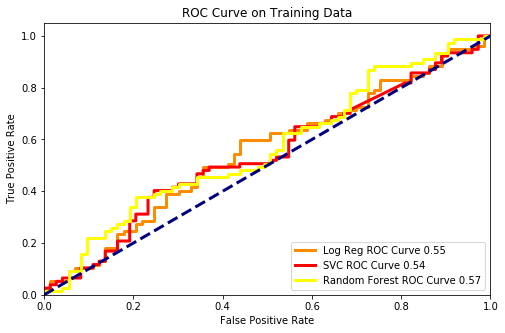

In [122]:
# Plot 
plt.figure(figsize = (8,5))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "SVC ROC Curve %.2f" % roc_auc1)
plt.plot(fpr2, tpr2, lw = line_width, color="yellow", 
         label = "Random Forest ROC Curve %.2f" % roc_auc2)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [50]:
for prob in range(42, 55, 1):
    proba = prob/100
    
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
        lambda p: 1 if p > proba else 0)
    


    
    print('Test Logistic Regression :' + str(proba))

    print ("Return of Away Games: ", nba_test.groupby(
        "predicted_label_lr").away_payout.sum())
    print ("Return of Home Games: ", nba_test.groupby(
        "predicted_label_lr").home_payout.sum())
    
    print (" ")
   

    
  

Test Logistic Regression :0.42
Return of Away Games:  predicted_label_lr
0   -7.821
1    6.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     1.724
1   -14.185
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.43
Return of Away Games:  predicted_label_lr
0   -9.821
1    8.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     3.542
1   -16.003
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.44
Return of Away Games:  predicted_label_lr
0   -11.821
1    10.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     5.360
1   -17.821
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.45
Return of Away Games:  predicted_label_lr
0   -10.003
1     8.996
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0     3.360
1   -15.821
Name: home_payout, dtype: float64
 
Test Logistic Regression :0.46
Return of Away Games:  predicted_label_lr

### Threshold Analysis

For the Logisitic Regession Analysis .44 seems to consistently rank a the best threshold.   If you look at the ROC curve for logisitic regression you will see one jagged mark on the curve that might increase the ration at that point. Therefore, I change the classification to .44.  

In the Threshold Analysis for Random Forest and SVC the numbers suggested that .5 was as good a number as any.   The Roc curve does not show any enormous jumps in precision.  Running the model a number of times.  The maximum precision is usually between .49 and .51, with slight variations between running models depending on splits of the variables.  Therefore, I think it is best to leave it at .5.



In [51]:
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
    lambda p: 1 if p > .44 else 0)
    
    nba_test.loc[:, 'predicted_label_svc']= nba_test.predicted_proba_svcp.map(
    lambda p: 1 if p > .50 else 0)

In [52]:
nba_test['vote']= (nba_test.predicted_label_svc + 
                   nba_test.predicted_label_lr)

print(nba_test.vote.value_counts(normalize = True))
print(nba_test.groupby(['vote'])['away_payout'].sum())
print(nba_test.groupby(['vote'])['home_payout'].sum())

2    0.513333
0    0.293333
1    0.193333
Name: vote, dtype: float64
vote
0   -3.911
1   -7.001
2    9.905
Name: away_payout, dtype: float64
vote
0    -0.093
1     4.453
2   -16.821
Name: home_payout, dtype: float64


In [53]:
#Combined 
nba_test['vote_with_rf'] = (nba_test.predicted_label_svc + 
                            nba_test.predicted_label_lr +
                            nba_test.predicted_label_rf)

In [54]:
nba_test.vote_with_rf.value_counts(normalize = True)

3    0.493333
2    0.200000
1    0.173333
0    0.133333
Name: vote_with_rf, dtype: float64

In [55]:
nba_test.groupby(['vote_with_rf'])['away_payout'].sum()

vote_with_rf
0    -8.546
1     4.544
2    -8.001
3    10.996
Name: away_payout, dtype: float64

In [56]:
nba_test.groupby(['vote_with_rf'])['home_payout'].sum()

vote_with_rf
0     6.726
1    -6.910
2     5.362
3   -17.639
Name: home_payout, dtype: float64

In [57]:
print(nba_test.predicted_label_svc.head(10))
nba_test.groupby(['predicted_label_svc'])['predicted_proba_svcp'].mean()
    

10206    1
10207    1
10208    1
10242    1
10243    0
10244    1
10245    0
10246    0
10247    0
10248    0
Name: predicted_label_svc, dtype: int64


predicted_label_svc
0    0.484828
1    0.533714
Name: predicted_proba_svcp, dtype: float64

### Results 

I created two ensemble models.  One containing a vote of the Logistic Regress and the Support Vector Machine.  The second model included the Random Forest Classifier as well.  

The first model consistently returns positively for betting the away team when both models agree and betting the home team in all other cases.  It returns 14.265 units in 150 games for an average return of 9.5% per bet.

The second model included the Random Forest Classifier and followed the same pattern.  Bet the away team if all three models predicted the away game else bet the home team.  It returned 16.174 or 10.8 percent return.  

The Second model definitely had a little more variance but consistently return higher than the first model.   

<Container object of 150 artists>

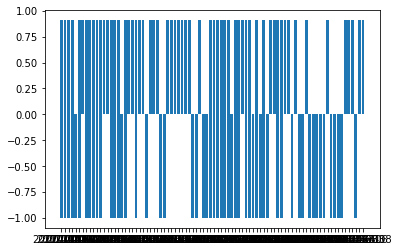

In [120]:
plt.bar(nba_test.date, nba_test.away_payout)